# PBMC3k dataset

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/pbmc3k.h5ad")):
    !sh /home/jovyan/data/pbmc3k.sh

In [2]:
from typing import NamedTuple
import warnings
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [3]:
class Config(NamedTuple):
    data: ad.AnnData = sc.read_h5ad("/home/jovyan/data/pbmc3k.h5ad")
    export: str = "/home/jovyan/output/pbmc3k"
    dsname: str = "PBMC3k"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)
warnings.filterwarnings("ignore")

In [4]:
sc.pp.filter_cells(conf.data, min_genes=200)
sc.pp.filter_genes(conf.data, min_cells=3)
conf.data.uns["dsname"] = conf.dsname

In [5]:
conf.data

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'dsname'

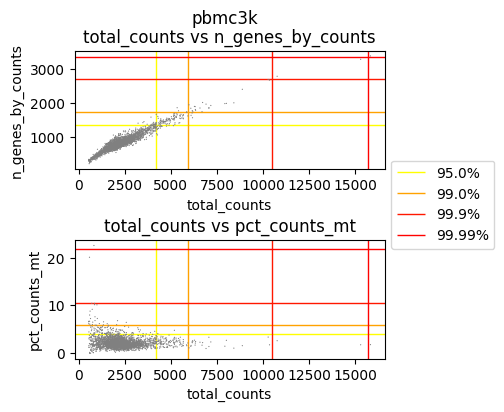

In [6]:
for k, v in {"pbmc3k": conf.data}.items():
    v.var['mt'] = v.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(v, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    plt.subplots_adjust(hspace=.6)

    for a, y in zip(ax, ["n_genes_by_counts", "pct_counts_mt"]):
        sc.pl.scatter(v, x="total_counts", y=y, ax=a, size=3, show=False)
        area = [.95, .99, .999, .9999]
        xlims, ylims = a.get_xlim(), a.get_ylim()
        for xval, yval, q in zip(
            get_quantiles(v, "total_counts", area=area),
            get_quantiles(v, y, area=area),
            area
        ):
            kwargs = dict(
                zorder=-1, linewidth=1, 
                color=plt.cm.autumn_r(q ** 100)
            )
            a.vlines(xval, *ylims, **kwargs)
            a.hlines(yval, *xlims, label=f"{100 * q}%", **kwargs)
        if y == "n_genes_by_counts":
            a.legend(loc="center left", bbox_to_anchor=(1, -.3))
        a.set_title(f"total_counts vs {y}")
        a.set(xlim=xlims, ylim=ylims)
        

    fig.suptitle(
        k,
        verticalalignment="center",
        y=.96
    );
    
    fig.savefig(f"{conf.export}/qc.png", **kwarg_savefig)

In [7]:
filter_dict = {
    "n_genes_by_counts": lambda x: x < 2500,
    "pct_counts_mt": lambda x: x < 10
}

In [8]:
conf = Config(data=filter_pipeline(conf.data, filter_dict))

In [9]:
sc.pp.normalize_total(conf.data, target_sum=1e6)
sc.pp.log1p(conf.data, base=2)

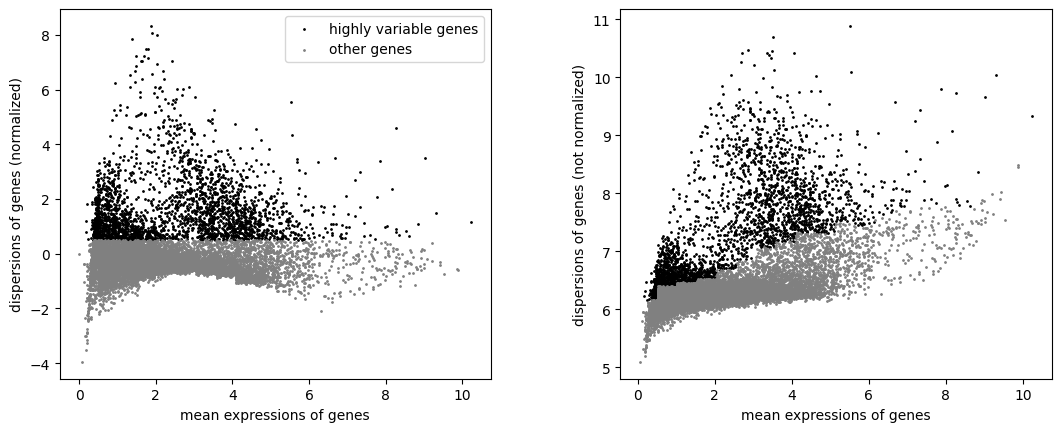

In [10]:
sc.pp.highly_variable_genes(
    conf.data, min_mean=0.0125, max_mean=15, min_disp=0.5
)
sc.pl.highly_variable_genes(conf.data, show=False)
plt.savefig(f"{conf.export}/hvg.png", **kwarg_savefig)

In [11]:
sc.tl.pca(conf.data, svd_solver='arpack')

In [12]:
sc.pp.neighbors(conf.data, n_pcs=50)

In [13]:
sc.tl.umap(conf.data)

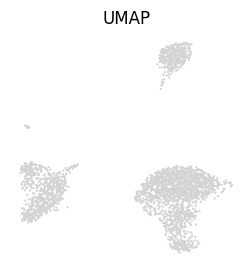

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, ax=ax, size=10, show=False)
ax.axis("off");
ax.set(title=f"UMAP", xlabel="UMAP1", ylabel="UMAP2");

In [15]:
sc.tl.leiden(conf.data, resolution=1)

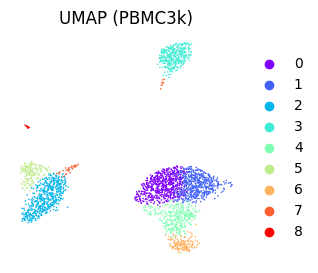

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, color="leiden", ax=ax, size=5, show=False, palette="rainbow")
ax.axis("off");
ax.set(title=f"UMAP ({conf.dsname})", xlabel="UMAP1", ylabel="UMAP2");

fig.savefig(f"{conf.export}/umap.png", **kwarg_savefig)

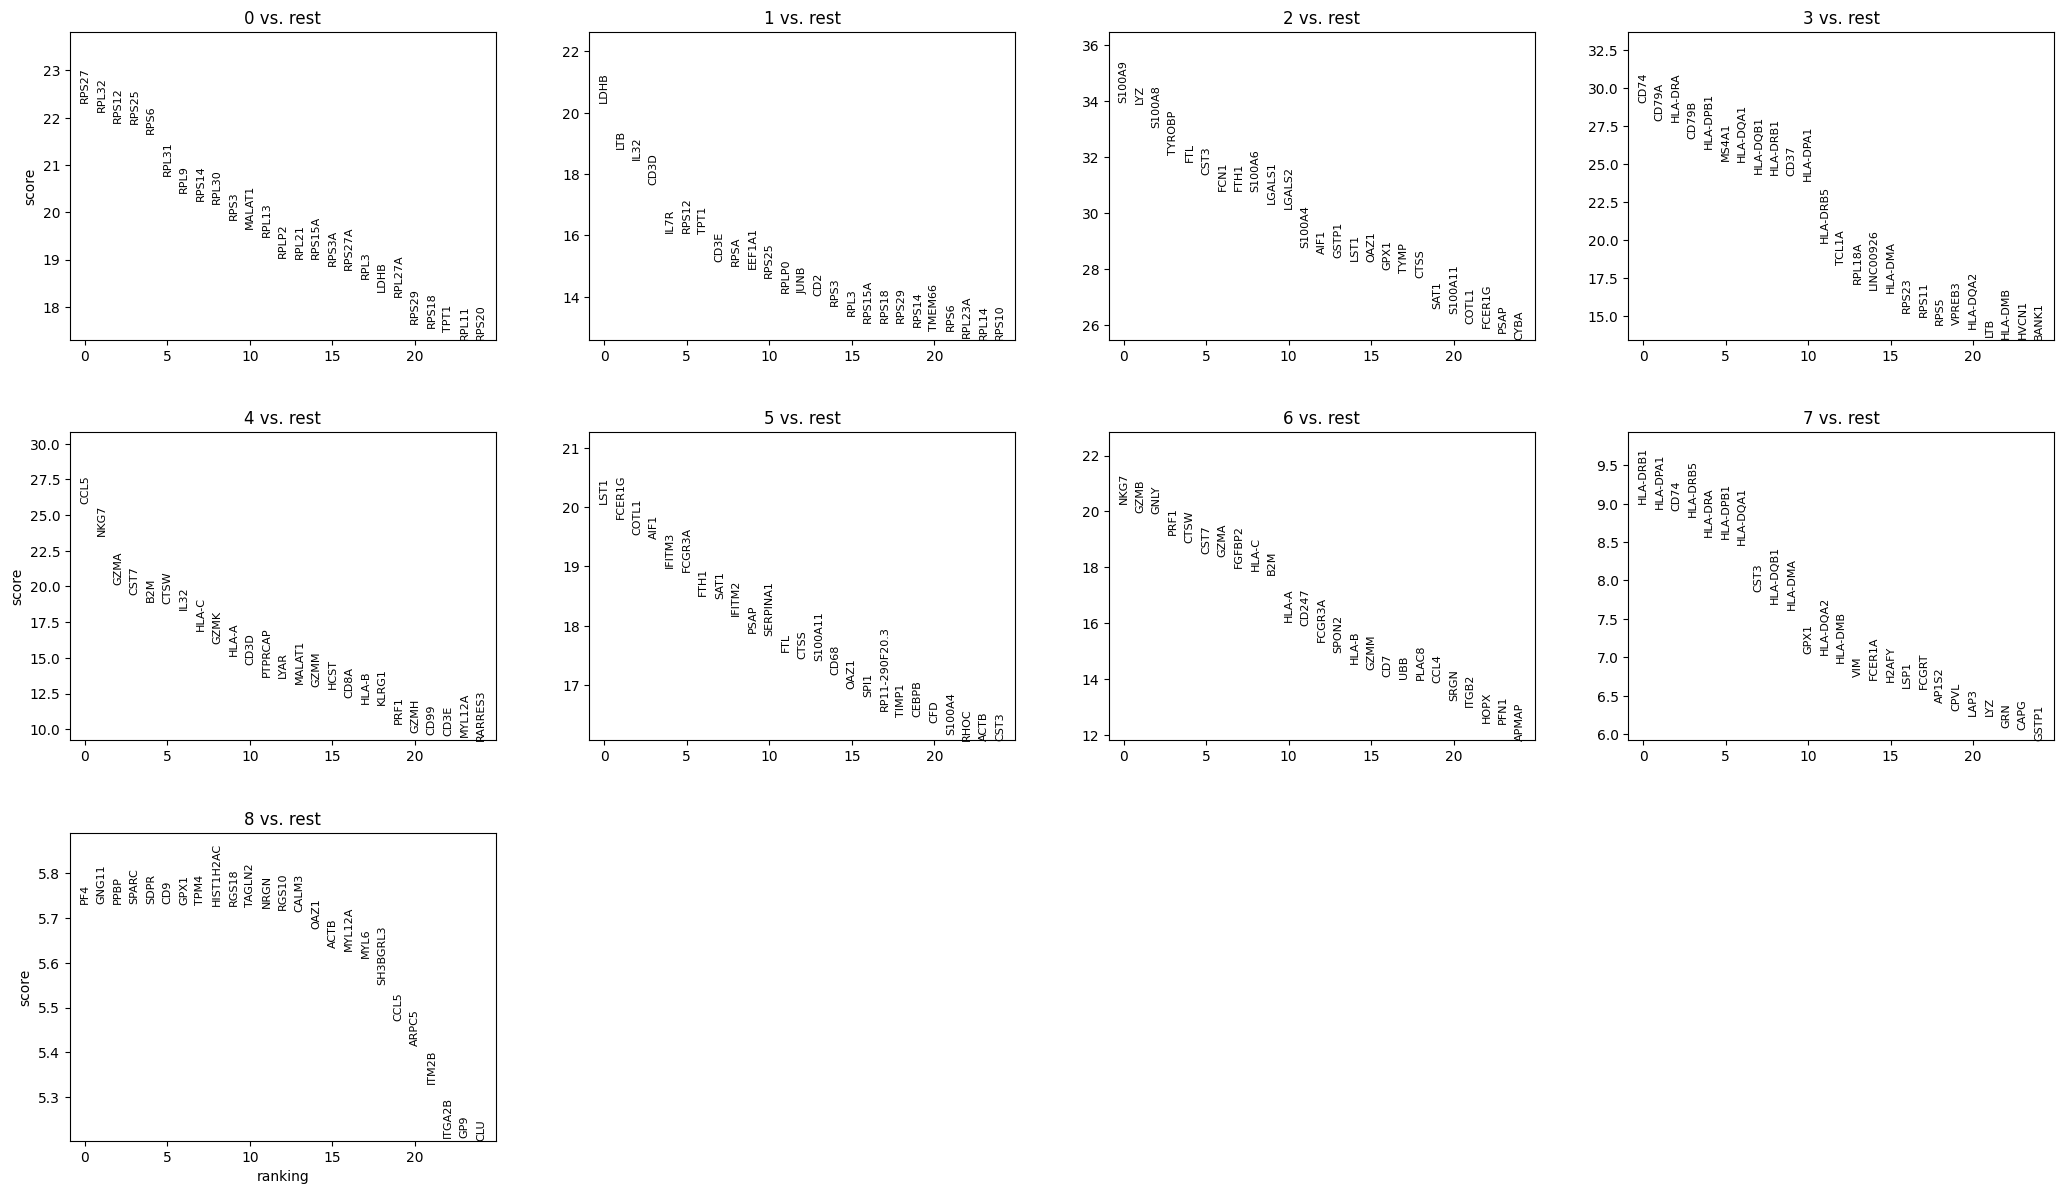

In [17]:
sc.tl.rank_genes_groups(conf.data, "leiden", method='wilcoxon')
sc.pl.rank_genes_groups(conf.data, n_genes=25, sharey=False)

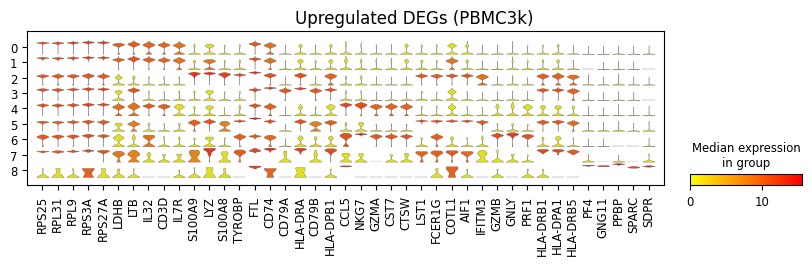

In [18]:
n = 5

fig, ax = plt.subplots(figsize=(10, 2))
sc.pl.stacked_violin(
    conf.data, top_degs(conf.data, n, min_logfc=1),
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(10, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

fig.savefig(
    f"{conf.export}/sigup_violin.png",
    **kwarg_savefig
)

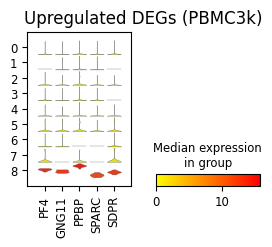

In [19]:
fig, ax = plt.subplots(figsize=(3, 2))
sc.pl.stacked_violin(
    conf.data, get_deg(conf.data, "8", min_logfc=1)[:5],
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(3, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

fig.savefig(
    f"{conf.export}/sigup_violin_8.png",
    **kwarg_savefig
)

In [20]:
from grnet.clusters import CellClasses
from grnet.models import PC, PretrainedModel
from grnet.plot import grnplot, planetplot

In [21]:
lst_data = [
    [
        conf.data[
            conf.data.obs["leiden"] == cluster_id,
            get_deg(conf.data, name, min_logfc=1)[:5]
        ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
    ] for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

In [22]:
models = [
    PC(lst_data[i // 9][i % 9].to_df()) for i in range(9 ** 2)
]

for m in models:
    m.estimate()

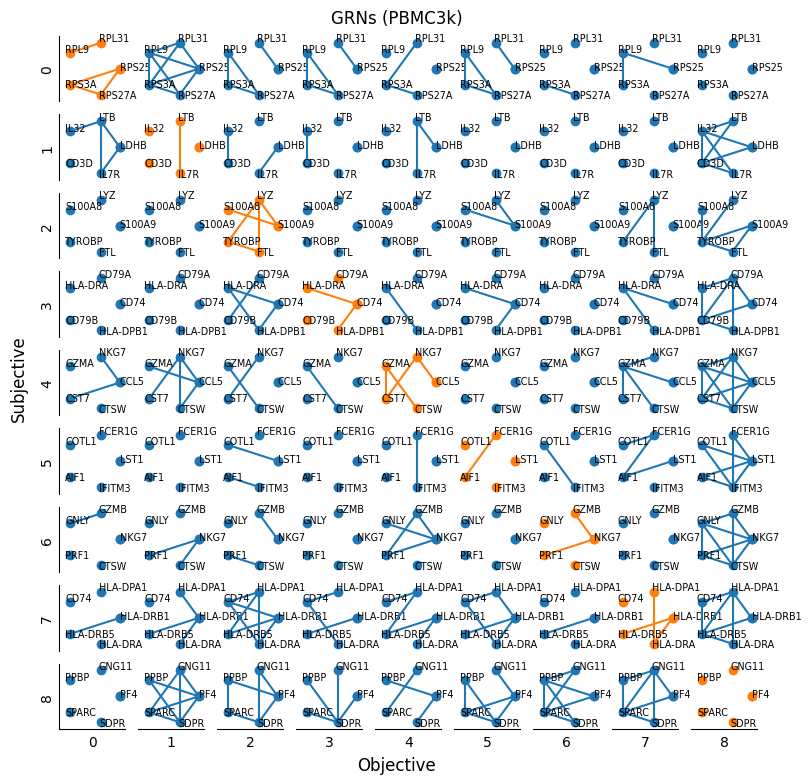

In [23]:
fig, ax = plt.subplots(9, 9, figsize=(9, 9))

for (i, m), a in zip(enumerate(models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i // 9 == i % 9 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(i // 9 == 8)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on") if (i // 9 == 8) | (i % 9 == 0) else None
    a.set(
        xlabel=names[i % 9] if i // 9 == 8 else "",
        ylabel=names[i // 9] if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.07)
fig.supxlabel("Objective", y=.06)
fig.suptitle(f"GRNs ({conf.dsname})", y=.91)

fig.savefig(f"{conf.export}/grns.png", **kwarg_savefig)

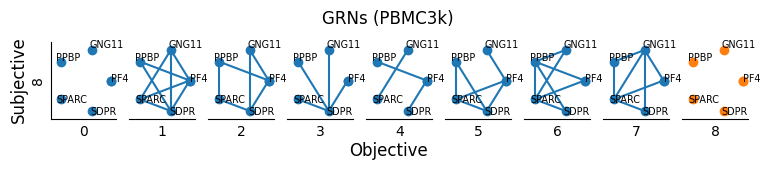

In [24]:
fig, ax = plt.subplots(1, 9, figsize=(9, 1))

for (i, m), a in zip(enumerate(models[-9:]), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i == 8 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(True)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on")
    a.set(
        xlabel=names[i % 9],
        ylabel=8 if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.08)
fig.supxlabel("Objective", y=-.3)
fig.suptitle(f"GRNs ({conf.dsname})", y=1.2)

fig.savefig(f"{conf.export}/grns_for_8.png", **kwarg_savefig)


NOTE: Dependency discovery took 150 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 88 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 87 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 86 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 86 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 90 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 87 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 88 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.



NOTE: Dependency discovery took 90 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.



Could not mmap compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


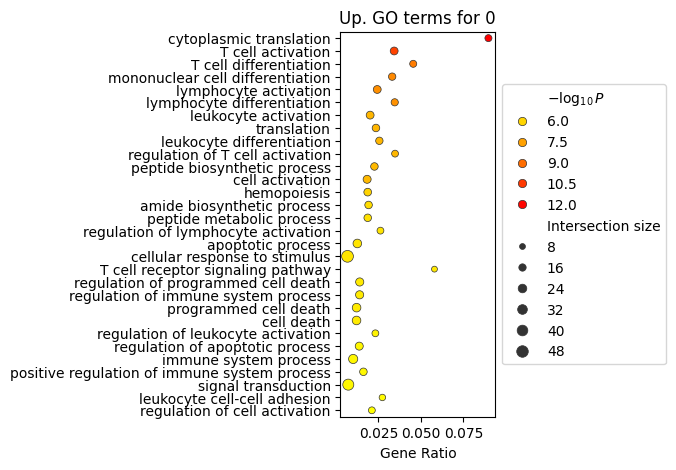

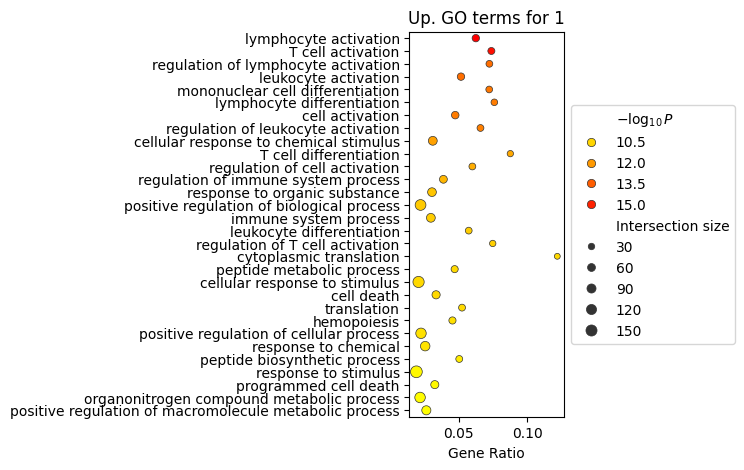

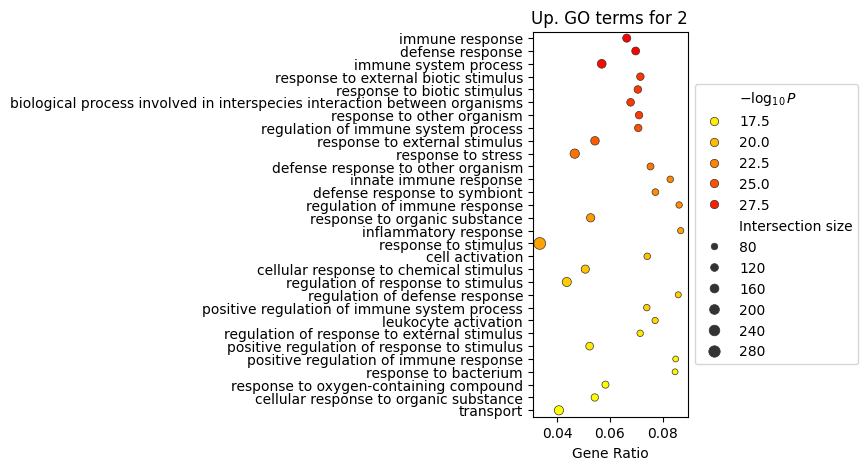

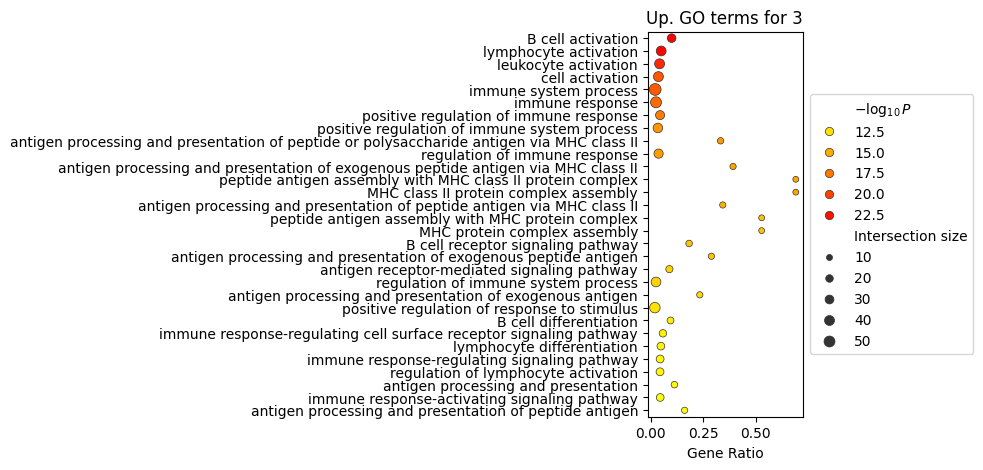

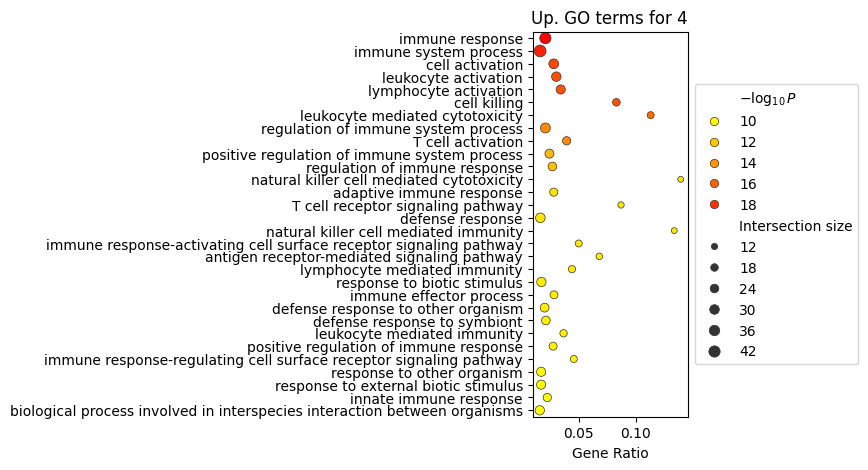

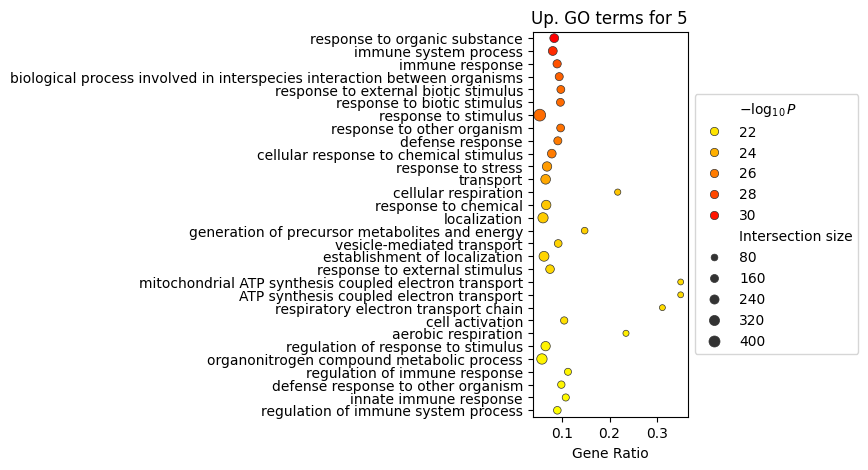

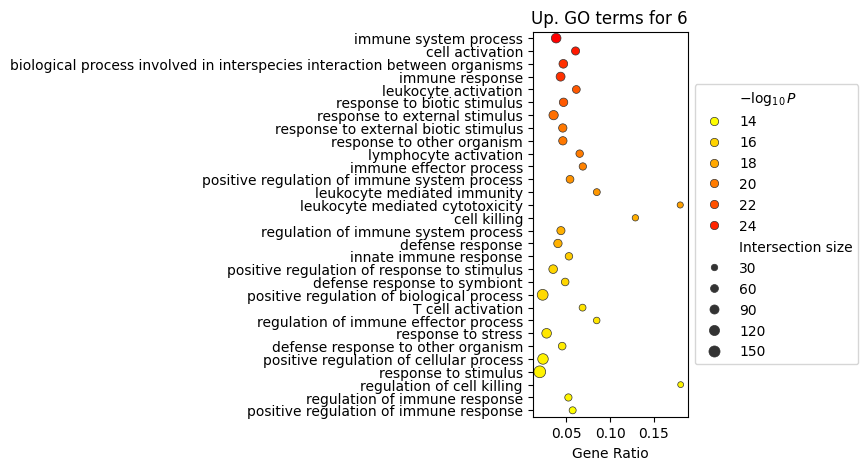

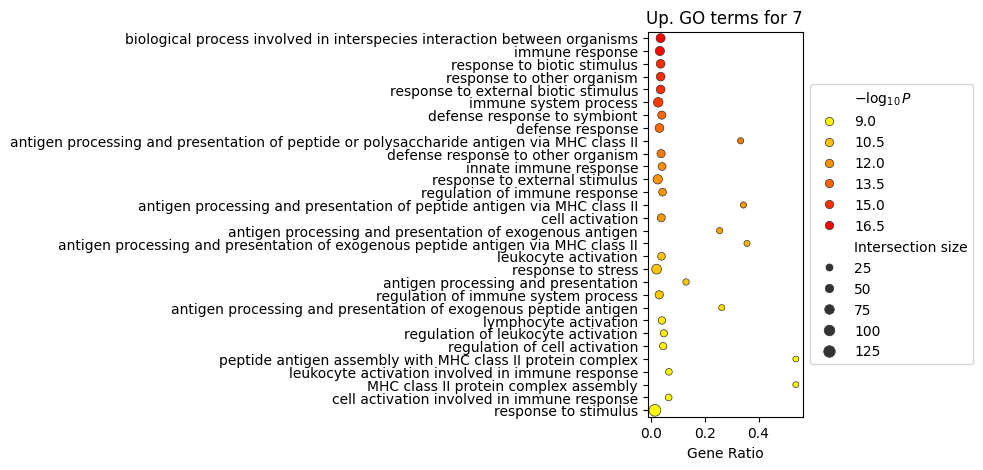

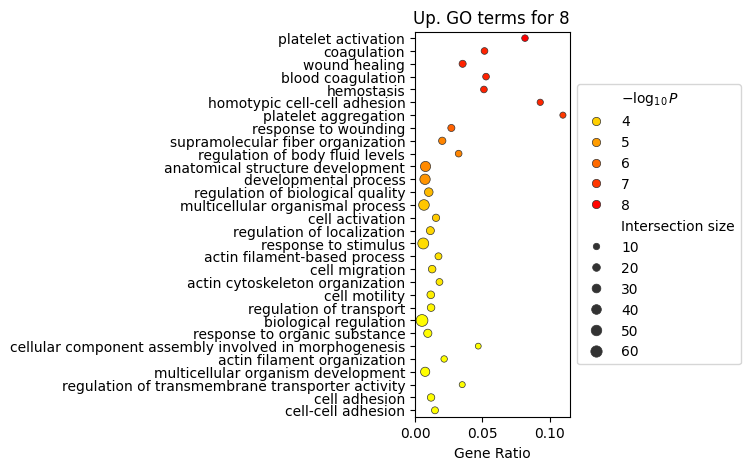

In [25]:
for k in conf.data.uns["rank_genes_groups"]["names"].dtype.names:
    if get_deg(conf.data, k, min_logfc=1).size != 0:
        fig, ax = plt.subplots(figsize=(2, 5))
        go_plot(conf.data, cluster_name=k, min_logfc=1, top=30, ax=ax, palette="autumn_r")
        ax.set_title(f"Up. GO terms for {k}", loc="right")
        fig.savefig(f"{conf.export}/go_{k}.png", **kwarg_savefig)

In [26]:
from grnet.evaluations import d_asterisk

In [27]:
metric_matrix = pd.DataFrame(
    np.array(
        [d_asterisk(
            models[9 * (i // 9) + (i // 9)].get_matrix(), 
            models[i].get_matrix()
        ) for i in range(9 ** 2)]
    ).reshape(9, 9),
    index=conf.data.uns["rank_genes_groups"]["names"].dtype.names,
    columns=conf.data.uns["rank_genes_groups"]["names"].dtype.names
)

In [28]:
import seaborn as sns

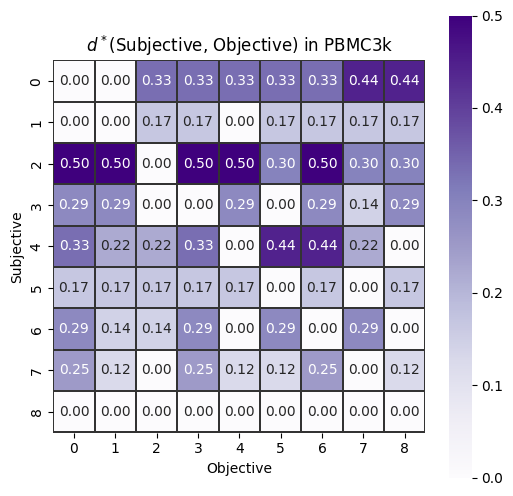

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(
    data=metric_matrix,
    square=True, vmin=0,
    annot=True, fmt=".2f",
    cmap="Purples", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set(
    ylabel="Subjective", 
    xlabel="Objective", 
    title="$d^*$" + "(Subjective, Objective)" + f" in {conf.dsname}"
);

fig.savefig(f"{conf.export}/dasterisk.png", **kwarg_savefig)

In [30]:
new_datalist = [
    conf.data[
        conf.data.obs["leiden"] == cluster_id,
        get_deg(conf.data, "8", min_logfc=1)[:10]
    ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

new_models = [
    PC(new_datalist[i].to_df()) for i in range(9)
]

for m in new_models:
    m.estimate()

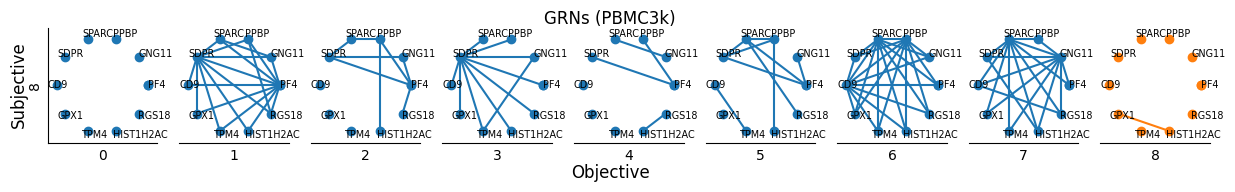

In [31]:
fig, ax = plt.subplots(1, 9, figsize=(15, 1.5))

for (i, m), a in zip(enumerate(new_models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i == 8 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(True)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on")
    a.set(
        xlabel=names[i % 9],
        ylabel=8 if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.1)
fig.supxlabel("Objective", y=-.15)
fig.suptitle(f"GRNs ({conf.dsname})", y=1)

fig.savefig(f"{conf.export}/grns_for_8_10degs.png", **kwarg_savefig)

In [32]:
new_d_mat = pd.DataFrame(
    [[d_asterisk(
        new_models[-1].get_matrix(),
        nm.get_matrix()
    ) for nm in new_models]],
    index=["8"],
    columns=conf.data.uns["rank_genes_groups"]["names"].dtype.names
)

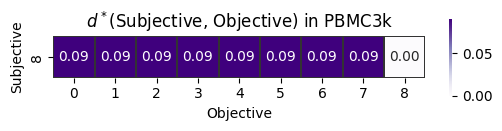

In [33]:
fig, ax = plt.subplots(figsize=(6, 1))

sns.heatmap(
    data=new_d_mat,
    square=True, vmin=0,
    annot=True, fmt=".2f",
    cmap="Purples", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set(
    ylabel="Subjective", 
    xlabel="Objective", 
    title="$d^*$" + "(Subjective, Objective)" + f" in {conf.dsname}"
);

fig.savefig(f"{conf.export}/dasterisk_for_8_10degs.png", **kwarg_savefig)

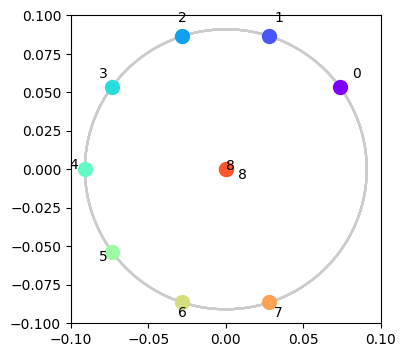

In [34]:
newds = CellClasses(
    models=new_models,
    colors="rainbow"
)

planetplot(subjective=newds, objective=newds, id=8, s=100)

# ML model

In [35]:
import optuna, lightgbm, shap

In [36]:
import optuna.integration.lightgbm as lgb
import lightgbm as lgbm

from sklearn.model_selection import train_test_split

In [37]:
x_tr, x_te, y_tr, y_te = train_test_split(
    conf.data.to_df(), 
    conf.data.obs["leiden"].astype(int),
    test_size=.2,
    random_state=0
)

x_tr, x_v, y_tr, y_v = train_test_split(
    x_tr, y_tr,
    test_size=.25,
    random_state=0
)

train = lgbm.Dataset(x_tr, y_tr)
valid = lgbm.Dataset(x_v, y_v)
test = lgbm.Dataset(x_te, y_te)

# params = dict(
#     objective="binary", metric="binary_logloss",
#     verbosity=-1, deterministic=True,
#     random_seed=0, num_boost_round=100,
#     force_col_wise=True
# )

params = dict(
    objective="multiclass", 
    metric="multi_logloss",
    num_class=conf.data.obs["leiden"].unique().size,
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

In [38]:
model = lgb.LightGBMTuner(
    params, train,
    valid_sets=valid,
    optuna_seed=0,
    verbosity=-1,
    callbacks=[lgbm.early_stopping(50), lgbm.log_evaluation(1000)]
)

[I 2024-05-09 23:02:52,220] A new study created in memory with name: no-name-90caa3c7-c7de-436a-8934-da3b9eab3a25


In [39]:
%%capture
model.run()

In [40]:
tuned = model.get_best_booster()

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, 
    average_precision_score
)

In [42]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [43]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AUC:{auc.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(roc.auc) - 1))
        )
    
    ax[-1].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c=".2",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(2)})"
    )
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax]
    ax[-1].set(title="ROC curve")
    [sp.legend(fontsize="small") for sp in ax]

In [44]:
testx = x_te.iloc[np.argsort(y_te)]
testy = y_te[np.argsort(y_te)]

In [45]:
label_bin = label_binarize(
    testy,
    classes = testy.unique()
)

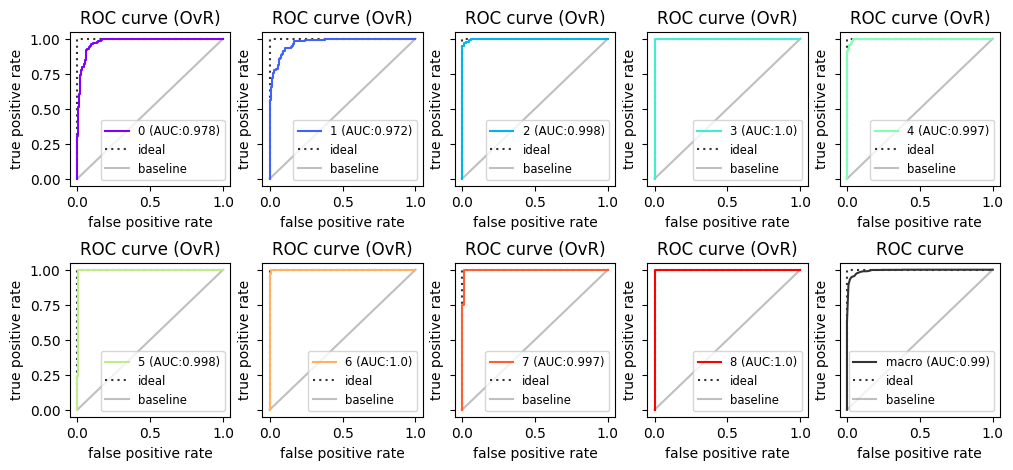

In [46]:
fig, ax = plt.subplots(2, 5, sharey=True, figsize=(12, 5))
plt.subplots_adjust(hspace=.5)

plot_roc(
    tuned, testx, label_bin, 
    ax, cmap="rainbow",
    label_dict={v: i for i, v in enumerate(testy.unique())}
)

fig.savefig(f"{conf.export}/roc.png", **kwarg_savefig)

In [47]:
class pr_multi():
    def __init__(self, model, x, y):
        self.x = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.y = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.thresh = [
            precision_recall_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.ap = [
            average_precision_score(y[:, i], model.predict(x)[:, i]) for i in range(y.shape[1])
        ]
        self.base = [len(y[:, i][y[:, i] == 1]) / len(y) for i in range(y.shape[1])]

In [48]:
def plot_pr(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    pr = pr_multi(model, x, y)
    ax = ax.ravel()
    
    for (i, x_), y_, ap, label, base in zip(enumerate(pr.x), pr.y, pr.ap, label_dict, pr.base):
        ax[i].plot(
            x_, y_, 
            label=f"{label} (AP:{ap.round(3)})", 
            c=eval(f"plt.cm.{cmap}")(i/(len(pr.ap) - 1))
        )
        ax[i].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    
    p_avg, r_avg, thr_avg = precision_recall_curve(y.ravel(), model.predict(x).ravel())
    
    ax[-1].plot(
        r_avg, p_avg, 
        c=".2", 
        label=f"micro (AP:{average_precision_score(y, model.predict(x)).round(2)})"
    )
    base = np.array(pr.base).mean()
    ax[-1].plot([0, 1], [base, base], c="gray", label="baseline", zorder=1, alpha=0.5)
    ax[-1].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 1], [1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=2) for sp in ax]
    [sp.set(xlabel="recall", ylabel="precision", title="PR curve (OvR)") for sp in ax] 
    ax[-1].set(title="PR curve")
    [sp.legend(fontsize="small") for sp in ax]

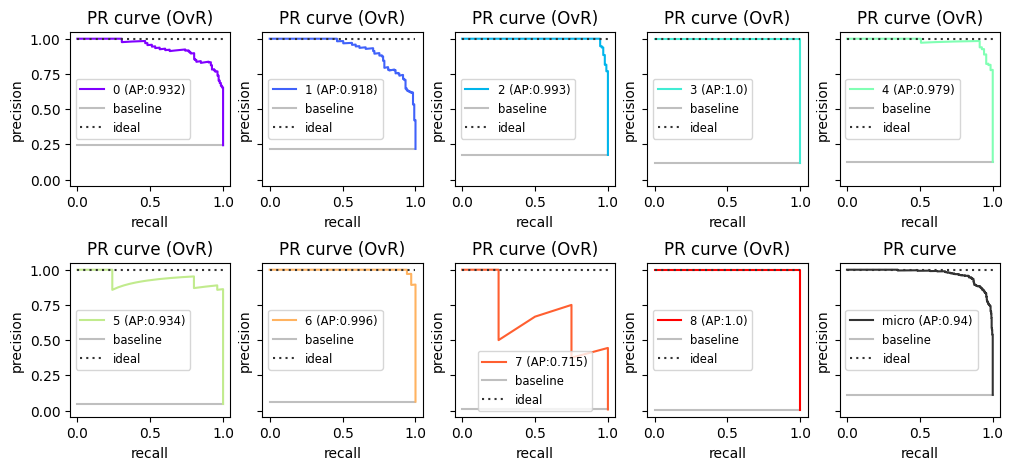

In [49]:
fig, ax = plt.subplots(2, 5, sharey=True, figsize=(12, 5))
plt.subplots_adjust(hspace=.5)

plot_pr(
    tuned, testx, label_bin, 
    ax, cmap="rainbow",
    label_dict={v: i for i, v in enumerate(testy)}
)

fig.savefig(f"{conf.export}/pr.png", **kwarg_savefig)

In [50]:
shap.initjs()

In [51]:
explainer = shap.TreeExplainer(model=tuned)
shap_values = explainer.shap_values(X=testx)

In [52]:
for i, v in enumerate(shap_values):
    plt.axes(title=f"cluster: {i} (PBMC3k)")
    shap.summary_plot(
        v, testx, 
        max_display=10, 
        show=False,
        plot_size=(4, 3),
    )
    plt.savefig(f"{conf.export}/shap_{i}.png", **kwarg_savefig)
    plt.close()

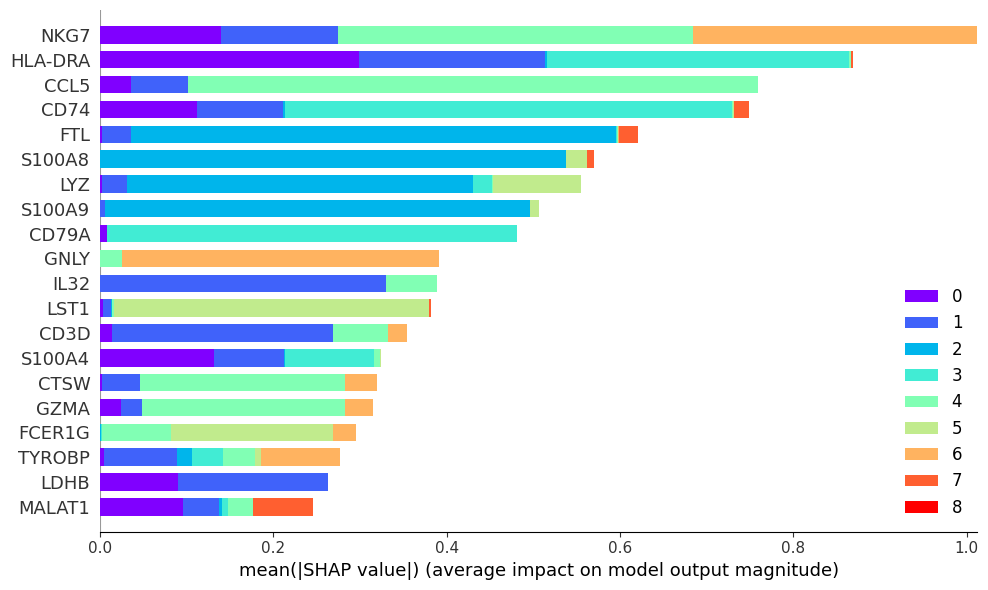

In [53]:
shap.summary_plot(
    shap_values, testx, 
    show=False, 
    color=lambda x: plt.cm.rainbow(x/8),
    plot_type="bar",
    plot_size=(10, 6),
    class_names=testy.unique(),
    class_inds="original"
)

plt.savefig(f"{conf.export}/shap.png", **kwarg_savefig)

In [54]:
df_fi = pd.DataFrame(
    tuned.feature_importance("gain"),
    index=conf.data.var.index,
    columns=["gain"]
).sort_values("gain", ascending=False)

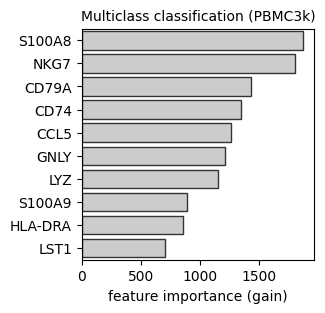

In [55]:
fig, ax = plt.subplots(figsize=(3, 3))

sns.barplot(
    data=df_fi.iloc[:10, :],
    x="gain",
    y=df_fi.iloc[:10, :].index,
    ax=ax, color=".8", edgecolor=".2"
)
ax.set(
    xlabel="feature importance (gain)",
    ylabel=""
)
ax.set_title(
    "Multiclass classification (PBMC3k)",
    size="medium"
)

plt.savefig(f"{conf.export}/fi.png", **kwarg_savefig)

In [56]:
ad_test = conf.data[testx.index]
ad_test.obs["prediction"] = np.argmax(
    tuned.predict(testx), 
    axis=1
).astype(str)

... storing 'prediction' as categorical


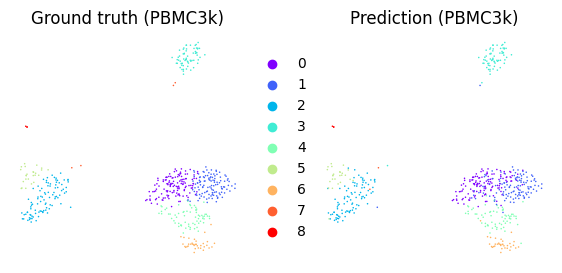

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(wspace=.3)

for a, hue, title in zip(
    ax,
    ["leiden", "prediction"],
    ["Ground truth", "Prediction"]
):
    sc.pl.umap(
        ad_test, color=hue, 
        ax=a, size=5, show=False, 
        palette="rainbow"
    )
    a.axis("off");
    a.set(title=f"{title} ({conf.dsname})");
    a.get_legend().remove() if hue == "prediction" else None

fig.savefig(f"{conf.export}/umap_prediction.png", **kwarg_savefig)

In [58]:
ad_test.obs["tf"] = (
    ad_test.obs["leiden"] == ad_test.obs["prediction"]
).astype(str)

... storing 'tf' as categorical


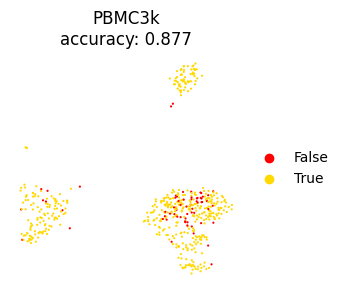

In [59]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(
    ad_test, color="tf", 
    ax=ax, size=10, 
    show=False, palette=[plt.cm.autumn(i * 0.85) for i in range(2)]
)
acc = (
    ad_test.obs["tf"].value_counts() / ad_test.obs["tf"].size
)["True"]
ax.axis("off");
ax.set(title=f"{conf.dsname}" + "\n" + f"accuracy: {acc.round(3)}");

fig.savefig(f"{conf.export}/accuracy.png", **kwarg_savefig)

# Logistic Model for DOR

In [20]:
from grnet.anndata.preprocessing import binarize
from tools.dor.metrics import mae, mse, horizontal_mae, horizontal_maxae
from tools.dor.models import LogisticModel, NegativeBinomial, Poisson

In [21]:
binarize(conf.data).write(
    "/home/jovyan/data/pbmc3k_bin.h5ad"
)

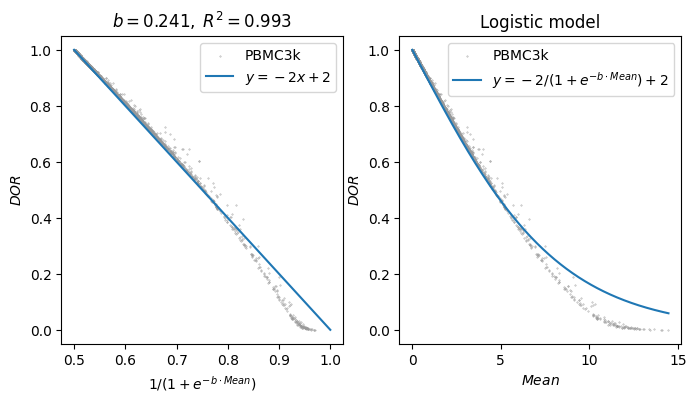

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

lm = LogisticModel()
lm.fit(binarize(conf.data))
lm.plot(ax=ax[0], label=f"{conf.dsname}")
lm.calibration_plot(ax=ax[-1], label=f"{conf.dsname}", linelabel=lm.formula)
ax[-1].set(title="Logistic model")

fig.savefig(f"{conf.export}/calibration_curve.png", **kwarg_savefig)

In [26]:
poi = Poisson()
poi.fit(binarize(conf.data))
nb = NegativeBinomial()
nb.fit(binarize(conf.data))

In [27]:
from sklearn.metrics import mean_squared_error as mse

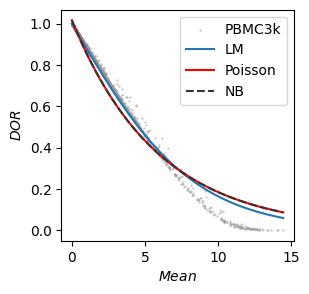

In [32]:
fig, ax = plt.subplots(figsize=(3, 3))

lm.calibration_plot(ax, label=f"{conf.dsname}")
poi.calibration_plot(ax, hide_dots=True, linecolor="r")
nb.calibration_plot(ax, hide_dots=True, linecolor=".2", linestyle="--")

fig.savefig(f"{conf.export}/model_comparison.png", **kwarg_savefig)

In [33]:
from tools.dor.metrics import mse, mae, horizontal_mae, horizontal_maxae

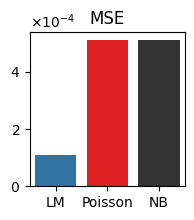

In [46]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.barplot(
    data=pd.DataFrame({
        "mse": [m.mse for m in [lm, poi, nb]],
        "model": [m.name for m in [lm, poi, nb]]
    }),
    x="model", y="mse", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"]
)

ax.ticklabel_format(
    axis="y", style="sci", scilimits=(-5, -4), useMathText=True
)

ax.set(xlabel="", ylabel="", title="MSE")

fig.savefig(f"{conf.export}/mse.png", **kwarg_savefig)

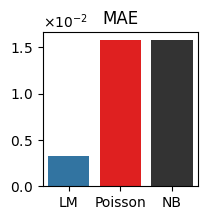

In [45]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.barplot(
    data=pd.DataFrame({
        "mae": [mae(m.y, m.f(m.x)) for m in [lm, poi, nb]],
        "model": [m.name for m in [lm, poi, nb]]
    }),
    x="model", y="mae", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"]
)

ax.ticklabel_format(
    axis="y", style="sci", scilimits=(-5, -4), useMathText=True
)

ax.set(xlabel="", ylabel="", title="MAE")

fig.savefig(f"{conf.export}/mae.png", **kwarg_savefig)

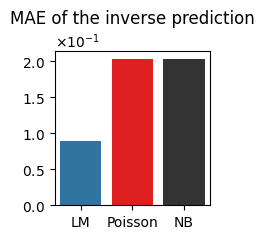

In [56]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.barplot(
    data=pd.DataFrame({
        "inv_mae": [
            horizontal_mae(m.x, m.y, m.predict_mean) for m in [lm, poi, nb]
        ],
        "model": [m.name for m in [lm, poi, nb]]
    }),
    x="model", y="inv_mae", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"]
)

ax.ticklabel_format(
    axis="y", style="sci", scilimits=(-5, -4), useMathText=True
)

ax.set(xlabel="", ylabel="", title="MAE of the inverse prediction")

fig.savefig(f"{conf.export}/inv_mae.png", **kwarg_savefig)

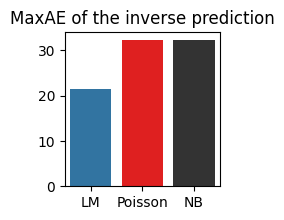

In [53]:
fig, ax = plt.subplots(figsize=(2, 2))

sns.barplot(
    data=pd.DataFrame({
        "inv_maxae": [
            horizontal_maxae(m.x, m.y, m.predict_mean) for m in [lm, poi, nb]
        ],
        "model": [m.name for m in [lm, poi, nb]]
    }),
    x="model", y="inv_maxae", hue="model", ax=ax,
    linewidth=0, palette=["C0", "r", ".2"]
)

ax.set(xlabel="", ylabel="", title="MaxAE of the inverse prediction")

fig.savefig(f"{conf.export}/inv_maxae.png", **kwarg_savefig)

In [57]:
def crosstable(
    data: ad.AnnData,
    x: str,
    y: str,
    ax: plt.Axes = None,
    jitter: float = 1,
    c: str = None,
    s: float = 1,
    annot: bool = False,
    seed: int = 0,
    ticklabels: list = ["–", "+"]
) -> None:
    if ax is None:
        _, ax = plt.subplots()
    if not "binarized" in data.uns:
        data = binarize(data)
    np.random.seed(seed)
    df = data.to_df().astype(int) + jitter * np.random.randn(*data.shape) / 10
    ax.axhline(.5, 0, 1, linewidth=1, c=".2")
    ax.axvline(.5, 0, 1, linewidth=1, c=".2")
    ax.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False
    )
    ax.scatter(df[x], df[y], s=s, c=c)
    ax.set(xlabel=x, ylabel=y)
    ax.set_xticks([0, 1]), ax.set_yticks([0, 1])
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.set_xlim([min(-.5, xlim[0]), max(1.5, xlim[1])])
    ax.set_ylim([min(-.5, ylim[0]), max(1.5, ylim[1])])
    if annot:
        tally = data[:, [x, y]].to_df().value_counts()
        txts = {
            b1: {
                b2: tally[b1][b2] if (b1, b2) in tally.index else 0 for b2 in [True, False]
            } for b1 in [True, False]
        }
        ax.text(0, 0, txts[False][False], ha="center", va="center")
        ax.text(1, 0, txts[True][False], ha="center", va="center")
        ax.text(0, 1, txts[False][True], ha="center", va="center")
        ax.text(1, 1, txts[True][True], ha="center", va="center")

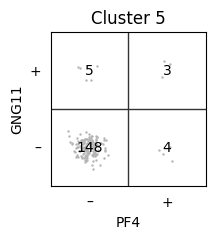

In [58]:
fig, ax = plt.subplots(figsize=(2, 2))

cluster_id = "5"

crosstable(
    data=conf.data[
        conf.data.obs["leiden"] == cluster_id, 
        get_deg(conf.data, "8", min_logfc=1)[:5]
    ],
    x="PF4", y="GNG11", ax=ax, jitter=1, c=".7", s=.5,
    annot=True
)

ax.set(title=f"Cluster {cluster_id}")

fig.savefig(
    f"{conf.export}/crosstable.png",
    **kwarg_savefig
)

In [78]:
fa = lambda n: np.prod(np.arange(1, n + 1))

In [79]:
fa(8) * fa(153) * fa(152) * fa(7) / (fa(160) * fa(5) * fa(3) * fa(148) * fa(4))

nan

In [80]:
from scipy.stats import fisher_exact
res = fisher_exact(np.array([[0, 11], [0, 0]]), alternative='two-sided')
res.pvalue

1.0

<Axes: ylabel='coverage'>

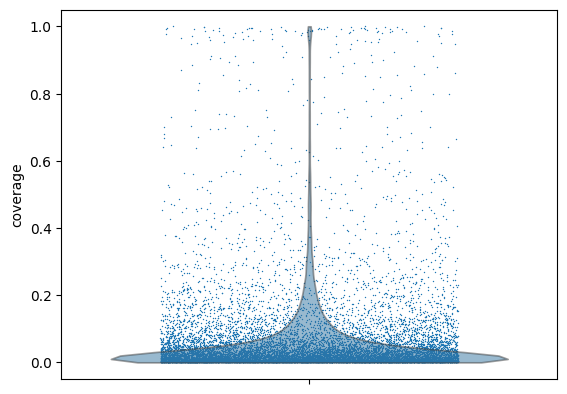

In [81]:
sns.violinplot(
    data=binarize(conf.data).var["coverage"],
    inner=None, cut=0,
    alpha=.5, color="C0"
)
sns.stripplot(
    data=binarize(conf.data).var["coverage"],
    s=1,
    jitter=.3,
    zorder=0, color="C0"
)

In [87]:
simsym = [
    v for v in ['ITGA2B', 'ITGB3', 'NFE2', 'GATA1', 'AKT3', 'MED6', 'NAALAD2',
       'GNPDA1', 'HDAC5'] if v in conf.data.var_names
]

Text(0.5, 1.0, 'Upregulated DEGs (PBMC3k)')

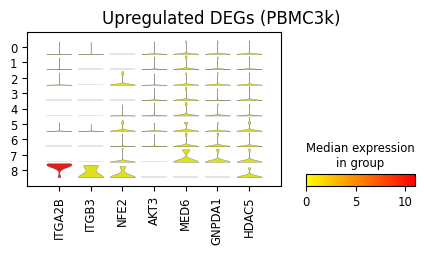

In [88]:
fig, ax = plt.subplots(figsize=(5, 2))
sc.pl.stacked_violin(
    conf.data, simsym,
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(5, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

# fig.savefig(
#     f"{conf.export}/sigup_violin_8.png",
#     **kwarg_savefig
# )

In [1004]:
"NFE2" in conf.data.var_names

True

In [1003]:
conf.data.var.filter(axis=0, regex="CD42")

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm


In [1001]:
conf.data.var.gene_ids[conf.data.var.gene_ids == "ENSG00000102145"]

Series([], Name: gene_ids, dtype: object)

In [775]:
get_deg(conf.data, "8", min_logfc=1)[:5]

array(['PF4', 'GNG11', 'PPBP', 'SPARC', 'SDPR'], dtype=object)

In [1050]:
from mygene import MyGeneInfo

In [1051]:
def goid2sym(
    goid: str,
    species: str = "human"
) -> pd.DataFrame:
    query_values = pd.DataFrame(
        list(
            MyGeneInfo().query(
                goid,
                scopes="go", 
                fields="symbol",
                species=species,
                fetch_all = True
            )
        )
    )
    return pd.DataFrame({
        "id": [goid for i in range(len(query_values))],
        "symbol": query_values.symbol 
    })

In [1058]:
list(MyGeneInfo().querymany(
    ['ITGA2B', 'ITGB3'],
    scopes="symbol", 
    fields="term",
    species="human",
    fetch_all = True
))

INFO:biothings.client:querying 1-2...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'ITGA2B', 'notfound': True}, {'query': 'ITGB3', 'notfound': True}]